<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled286.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab setup: ensure ffmpeg is available for MP4 writing
!apt-get -qq update
!apt-get -qq install -y ffmpeg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
import matplotlib
matplotlib.rcParams["animation.embed_limit"] = 50  # MB, inline embed limit

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Saved: gc_governance_movie.mp4


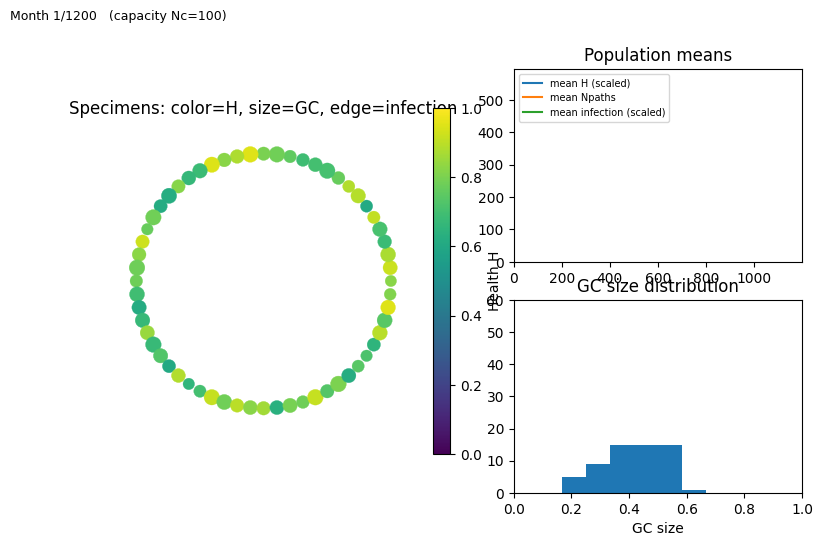

In [ ]:
# -----------------------------
# Toy "GC governance game" movie generator
# (Conceptual / illustrative, not biological truth)
# -----------------------------
rng = np.random.default_rng(7)

T = 1200        # frames (months)
n_agents = 60  # specimens

# State variables per specimen
age = np.zeros(n_agents)
sag = np.zeros(n_agents)                      # 0..1 architectural loosening
H = rng.uniform(0.6, 0.95, n_agents)          # 0..1 health
immune_skill = rng.uniform(0.4, 0.8, n_agents)

gc_size = rng.uniform(0.2, 0.6, n_agents)      # 0..1
Npaths = rng.uniform(20, 60, n_agents)         # effective dimensionality proxy
inf_burden = np.zeros(n_agents)                # 0..6

# Ecology / capacity parameters
base_infection_rate = 0.10
season_amp = 0.06
Nc = 100.0
m_base = 0.35

# Storage for population means
mean_H = np.zeros(T)
mean_N = np.zeros(T)
mean_inf = np.zeros(T)

def seasonality(t):
    return season_amp * (1 + np.sin(2*np.pi*(t % 12)/12.0 - np.pi/2))

def step(t):
    global age, sag, H, immune_skill, gc_size, Npaths, inf_burden

    # ageing + sag drift
    age += 1.0
    sag[:] = np.clip(sag + 0.0012 + 0.002*(1-H) + rng.normal(0, 0.001, n_agents), 0, 1)

    # infection events (shared ecology + individual susceptibility)
    lam = base_infection_rate + seasonality(t)
    susceptibility = np.clip(0.6*sag + 0.4*(1-immune_skill) + 0.2*(1-H), 0, 1)
    p_inf = np.clip(lam * (0.5 + susceptibility), 0, 0.9)
    new_inf = rng.random(n_agents) < p_inf
    inf_burden[:] = np.clip(inf_burden*0.85 + new_inf.astype(float), 0, 6)

    # GC response: grow with infection but shrink with sag/low health
    gc_activation = new_inf.astype(float) * (0.7 + 0.3*immune_skill)
    gc_size[:] = np.clip(gc_size + 0.10*gc_activation + 0.03*inf_burden - 0.06*sag - 0.02*(1-H), 0, 1)

    # effective coupling increases with sag and burden
    m_eff = np.clip(m_base + 0.4*sag + 0.2*(inf_burden/6.0), 0, 1)

    # Npaths grows with GC activity + coupling; relaxes when GC low
    Npaths[:] = np.clip(Npaths + 6*gc_size*m_eff - 2.0*(1-gc_size), 5, 600)

    # governance overload when Npaths exceeds capacity
    overload = np.clip((Npaths - Nc)/Nc, 0, 5)

    # health erosion from overload + infection; partial recovery when low burden
    dH = -0.02*overload - 0.01*(inf_burden/6.0) + 0.004*(inf_burden < 1.0) - 0.005*sag
    H[:] = np.clip(H + dH + rng.normal(0, 0.0025, n_agents), 0.05, 0.99)

    # immune_skill adapts slowly, degraded by overload
    immune_skill[:] = np.clip(immune_skill + 0.001*(inf_burden < 1.0) - 0.003*overload + rng.normal(0,0.001,n_agents), 0.05, 0.98)

# Pre-run means (so axes are stable)
for t in range(T):
    step(t)
    mean_H[t] = H.mean()
    mean_N[t] = Npaths.mean()
    mean_inf[t] = inf_burden.mean()

# Reset for snapshots
rng = np.random.default_rng(7)
age = np.zeros(n_agents)
sag = np.zeros(n_agents)
H = rng.uniform(0.6, 0.95, n_agents)
immune_skill = rng.uniform(0.4, 0.8, n_agents)
gc_size = rng.uniform(0.2, 0.6, n_agents)
Npaths = rng.uniform(20, 60, n_agents)
inf_burden = np.zeros(n_agents)

snap_H, snap_gc, snap_inf = [], [], []
for t in range(T):
    step(t)
    snap_H.append(H.copy())
    snap_gc.append(gc_size.copy())
    snap_inf.append(inf_burden.copy())

# -----------------------------
# Build animation
# -----------------------------
fig = plt.figure(figsize=(9, 5.5))
gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1.0], height_ratios=[1, 1])
ax_sc = fig.add_subplot(gs[:, 0])
ax_ts = fig.add_subplot(gs[0, 1])
ax_hist = fig.add_subplot(gs[1, 1])

# Arrange specimens on circle for readability
theta = np.linspace(0, 2*np.pi, n_agents, endpoint=False)
xy = np.c_[np.cos(theta), np.sin(theta)]

sc = ax_sc.scatter(xy[:,0], xy[:,1], s=60, c=snap_H[0], cmap="viridis", vmin=0, vmax=1)
ax_sc.set_title("Specimens: color=H, size=GC, edge=infection")
ax_sc.set_xlim(-1.25, 1.25)
ax_sc.set_ylim(-1.25, 1.25)
ax_sc.set_aspect("equal")
ax_sc.axis("off")
fig.colorbar(sc, ax=ax_sc, fraction=0.05, pad=0.03, label="Health H")

# Time series (scaled for one-axis display)
H_scale = mean_N.max()
I_scale = mean_N.max()/6.0
lineH, = ax_ts.plot([], [], label="mean H (scaled)")
lineN, = ax_ts.plot([], [], label="mean Npaths")
lineI, = ax_ts.plot([], [], label="mean infection (scaled)")
ax_ts.set_xlim(0, T-1)
ax_ts.set_ylim(0, mean_N.max()*1.1)
ax_ts.set_title("Population means")
ax_ts.legend(fontsize=7, loc="upper left")

# Histogram of GC size
bins = np.linspace(0, 1, 13)
bars = ax_hist.bar(bins[:-1], np.zeros(len(bins)-1), width=np.diff(bins), align="edge")
ax_hist.set_xlim(0, 1)
ax_hist.set_ylim(0, n_agents)
ax_hist.set_title("GC size distribution")
ax_hist.set_xlabel("GC size")

ttext = fig.text(0.02, 0.97, "", fontsize=9)

def update(k):
    Hk = snap_H[k]
    gk = snap_gc[k]
    ik = snap_inf[k]

    sc.set_sizes(35 + 160*gk)
    sc.set_array(Hk)
    sc.set_linewidths(0.2 + 0.9*(ik/6.0))

    x = np.arange(k+1)
    lineH.set_data(x, mean_H[:k+1]*H_scale)
    lineN.set_data(x, mean_N[:k+1])
    lineI.set_data(x, mean_inf[:k+1]*I_scale)

    counts, _ = np.histogram(gk, bins=bins)
    for b, c in zip(bars, counts):
        b.set_height(c)

    ttext.set_text(f"Month {k+1}/{T}   (capacity Nc={Nc:.0f})")
    return sc, lineH, lineN, lineI, *bars

anim = FuncAnimation(fig, update, frames=T, interval=80, blit=False)

out_mp4 = "gc_governance_movie.mp4"
anim.save(out_mp4, writer=FFMpegWriter(fps=12))

print("Saved:", out_mp4)


In [ ]:
from IPython.display import Video
Video("gc_governance_movie.mp4", embed=True)

In [ ]:
import numpy as np

np.savez(
    "gc_governance_run.npz",
    # parameters
    T=T,
    n_agents=n_agents,
    Nc=Nc,
    m_base=m_base,
    base_infection_rate=base_infection_rate,
    season_amp=season_amp,

    # population means
    mean_H=mean_H,
    mean_Npaths=mean_N,
    mean_inf=mean_inf,

    # per-agent snapshots (time × agents)
    snap_H=np.array(snap_H),
    snap_gc_size=np.array(snap_gc),
    snap_inf_burden=np.array(snap_inf),
)

In [ ]:
# -----------------------------
# Infection events (define new_inf)
# -----------------------------
lam = base_infection_rate + seasonality(t)

susceptibility = np.clip(
    0.6*sag + 0.4*(1 - immune_skill) + 0.2*(1 - H),
    0, 1
)

p_inf = np.clip(lam * (0.5 + susceptibility), 0, 0.9)
new_inf = rng.random(n_agents) < p_inf

# Update infection burden
inf_burden[:] = np.clip(inf_burden*0.85 + new_inf.astype(float), 0, 6)

In [ ]:
# ============================================================
# FINITE-SLOT TRANSIENT GCs + MIGRATION/CONQUEST MIXING (MAIN BLOCK)
# ============================================================

# ---------- (A) INIT: run once AFTER you define rng, T, n_agents, and basic state arrays ----------
# Finite GC niche capacity ("slots") per specimen (organ-like constraint)
gc_slots = rng.integers(2, 7, n_agents)     # 2..6 niches per specimen
max_slots = int(gc_slots.max())

# Slot occupancy + age (transient GCs)
gc_slot_on  = np.zeros((n_agents, max_slots), dtype=bool)   # whether each slot is active
gc_slot_age = np.zeros((n_agents, max_slots), dtype=float)  # months since that GC started

# Start with a few active GCs
initial_occ = rng.integers(0, 2, n_agents)  # 0 or 1 active GC initially
for i in range(n_agents):
    if initial_occ[i] > 0:
        free = np.arange(max_slots)
        free = free[free < gc_slots[i]]
        if free.size > 0:
            j = rng.choice(free)
            gc_slot_on[i, j] = True
            gc_slot_age[i, j] = rng.uniform(0, 6)

# Derived scalars for plotting / downstream logic
gc_occ = gc_slot_on.sum(axis=1)             # number of active GCs (transient)
gc_drive = np.zeros(n_agents)               # antigenic drive memory (decays)
gc_size = np.zeros(n_agents)                # scalar GC activity proxy (0..1)


# ---------- (B) UPDATE: paste this INSIDE your step(t) AFTER you compute new_inf, inf_burden, sag, H, immune_skill ----------
# Antigenic drive accumulates with infection and decays
gc_drive = np.clip(gc_drive*0.90 + new_inf.astype(float)*(0.7 + 0.3*immune_skill), 0, 10)

# Seed probability rises with drive, falls with sag; limited by free slots
free_slots = gc_slots - gc_slot_on.sum(axis=1)
seed_prob = np.clip(0.05 + 0.20*(gc_drive/10.0) - 0.10*sag, 0, 0.6)
seed = (rng.random(n_agents) < seed_prob) & (free_slots > 0)

# Seed new GC into a random free slot within capacity
seed_idx = np.where(seed)[0]
for i in seed_idx:
    free = np.where(~gc_slot_on[i])[0]
    free = free[free < gc_slots[i]]  # only slots within that specimen's niche capacity
    if free.size > 0:
        j = rng.choice(free)
        gc_slot_on[i, j] = True
        gc_slot_age[i, j] = 0.0

# Age all occupied GCs
gc_slot_age[gc_slot_on] += 1.0

# GC death: higher hazard when old, when drive is low, and when sag is high
base_life = 10.0  # months (illustrative)
life = np.clip(base_life*(1 - 0.6*sag), 3.0, 12.0)
for i in range(n_agents):
    on = np.where(gc_slot_on[i])[0]
    if on.size == 0:
        continue
    # hazard per occupied slot (vector)
    hazard = 0.02 + 0.08*(gc_slot_age[i, on] > life[i]) + 0.10*(gc_drive[i] < 0.5) + 0.05*sag[i]
    hazard = np.clip(hazard, 0, 0.6)
    die = rng.random(on.size) < hazard
    if die.any():
        dying = on[die]
        gc_slot_on[i, dying] = False
        gc_slot_age[i, dying] = 0.0

# Derived GC variables (for plotting and dynamics)
gc_occ = gc_slot_on.sum(axis=1)
slot_activity = np.clip((gc_drive/5.0) * (1 - 0.7*sag) * (0.6 + 0.4*H), 0, 1)
gc_size = np.clip((gc_occ / np.maximum(gc_slots, 1)) * slot_activity, 0, 1)

# Migration / conquest mixing: separate from GC count (finite compartments can still mix strongly)
m_eff = np.clip(m_base + 0.5*sag + 0.25*(inf_burden/6.0), 0, 1)

# Mixing inflates effective independence (conquest couples compartments)
mix_inflation = 1.0 + 2.5*m_eff  # 1..3.5 multiplier

# Effective dimensionality proxy Npaths: grows with GC activity, inflated by mixing, relaxes when GC activity is low
Npaths = np.clip(
    Npaths + 8.0*gc_size*mix_inflation - 3.0*(gc_size < 0.2),
    5, 800
)
# ============================================================

In [ ]:
import numpy as np

# -----------------------------
# Parameters
# -----------------------------
rng = np.random.default_rng(7)

T = 48          # months/steps
n_agents = 60

base_infection_rate = 0.10
season_amp = 0.06

Nc = 100.0      # capacity bound (toy)
m_base = 0.35

# -----------------------------
# State variables (per specimen)
# -----------------------------
age = np.zeros(n_agents)
sag = np.zeros(n_agents)                          # 0..1
H = rng.uniform(0.6, 0.95, n_agents)              # 0..1
immune_skill = rng.uniform(0.4, 0.8, n_agents)    # 0..1

inf_burden = np.zeros(n_agents)                   # 0..6
Npaths = rng.uniform(20, 60, n_agents)            # effective dimensionality proxy

# -----------------------------
# Finite-slot transient GCs (init)
# -----------------------------
gc_slots = rng.integers(2, 7, n_agents)           # 2..6 niches per specimen
max_slots = int(gc_slots.max())

gc_slot_on  = np.zeros((n_agents, max_slots), dtype=bool)
gc_slot_age = np.zeros((n_agents, max_slots), dtype=float)

initial_occ = rng.integers(0, 2, n_agents)        # 0 or 1 initial GC
for i in range(n_agents):
    if initial_occ[i] > 0:
        free = np.arange(max_slots)
        free = free[free < gc_slots[i]]
        if free.size > 0:
            j = rng.choice(free)
            gc_slot_on[i, j] = True
            gc_slot_age[i, j] = rng.uniform(0, 6)

gc_drive = np.zeros(n_agents)                     # antigenic drive memory
gc_occ = gc_slot_on.sum(axis=1)                   # active GC count
gc_size = np.zeros(n_agents)                      # scalar activity proxy

def seasonality(t):
    return season_amp * (1 + np.sin(2*np.pi*(t % 12)/12.0 - np.pi/2))

def step(t):
    global age, sag, H, immune_skill, inf_burden, Npaths
    global gc_drive, gc_slot_on, gc_slot_age, gc_occ, gc_size

    # 1) Ageing + sag drift
    age[:] = age + 1.0
    sag[:] = np.clip(sag + 0.0012 + 0.002*(1 - H) + rng.normal(0, 0.001, n_agents), 0, 1)

    # 2) Infection draw -> new_inf (THIS is what was missing in your wiring)
    lam = base_infection_rate + seasonality(t)
    susceptibility = np.clip(0.6*sag + 0.4*(1 - immune_skill) + 0.2*(1 - H), 0, 1)
    p_inf = np.clip(lam * (0.5 + susceptibility), 0, 0.9)
    new_inf = rng.random(n_agents) < p_inf

    # Update infection burden
    inf_burden[:] = np.clip(inf_burden*0.85 + new_inf.astype(float), 0, 6)

    # 3) GC birth/death under finite slots
    gc_drive[:] = np.clip(gc_drive*0.90 + new_inf.astype(float)*(0.7 + 0.3*immune_skill), 0, 10)

    free_slots = gc_slots - gc_slot_on.sum(axis=1)
    seed_prob = np.clip(0.05 + 0.20*(gc_drive/10.0) - 0.10*sag, 0, 0.6)
    seed = (rng.random(n_agents) < seed_prob) & (free_slots > 0)

    for i in np.where(seed)[0]:
        free = np.where(~gc_slot_on[i])[0]
        free = free[free < gc_slots[i]]
        if free.size > 0:
            j = rng.choice(free)
            gc_slot_on[i, j] = True
            gc_slot_age[i, j] = 0.0

    gc_slot_age[gc_slot_on] += 1.0

    base_life = 10.0
    life = np.clip(base_life*(1 - 0.6*sag), 3.0, 12.0)
    for i in range(n_agents):
        on = np.where(gc_slot_on[i])[0]
        if on.size == 0:
            continue
        hazard = 0.02 + 0.08*(gc_slot_age[i, on] > life[i]) + 0.10*(gc_drive[i] < 0.5) + 0.05*sag[i]
        hazard = np.clip(hazard, 0, 0.6)
        die = rng.random(on.size) < hazard
        if die.any():
            dying = on[die]
            gc_slot_on[i, dying] = False
            gc_slot_age[i, dying] = 0.0

    gc_occ[:] = gc_slot_on.sum(axis=1)
    slot_activity = np.clip((gc_drive/5.0) * (1 - 0.7*sag) * (0.6 + 0.4*H), 0, 1)
    gc_size[:] = np.clip((gc_occ / np.maximum(gc_slots, 1)) * slot_activity, 0, 1)

    # 4) Migration / conquest mixing -> inflates effective dimensionality
    m_eff = np.clip(m_base + 0.5*sag + 0.25*(inf_burden/6.0), 0, 1)
    mix_inflation = 1.0 + 2.5*m_eff

    Npaths[:] = np.clip(Npaths + 8.0*gc_size*mix_inflation - 3.0*(gc_size < 0.2), 5, 800)

    # 5) Governance overload -> health + skill update
    overload = np.clip((Npaths - Nc) / Nc, 0, 5)
    dH = -0.02*overload - 0.01*(inf_burden/6.0) + 0.004*(inf_burden < 1.0) - 0.005*sag
    H[:] = np.clip(H + dH + rng.normal(0, 0.0025, n_agents), 0.05, 0.99)

    immune_skill[:] = np.clip(
        immune_skill + 0.001*(inf_burden < 1.0) - 0.003*overload + rng.normal(0, 0.001, n_agents),
        0.05, 0.98
    )

# -----------------------------
# RUN LOOP (THIS is the other thing people forget)
# -----------------------------
for t in range(T):
    step(t)

print("Done.")
print("mean H:", H.mean())
print("mean Npaths:", Npaths.mean(), "max Npaths:", Npaths.max())
print("mean gc_occ:", gc_occ.mean(), "mean gc_size:", gc_size.mean())
print("mean infection burden:", inf_burden.mean())

Done.
mean H: 0.8414113328339395
mean Npaths: 8.90832907213041 max Npaths: 57.56102685854741
mean gc_occ: 0.7666666666666667 mean gc_size: 0.04492714148427416
mean infection burden: 0.8063796540274196


In [ ]:
# -----------------------------
# RERUN WITH SNAPSHOTS (for movie + NPZ)
# -----------------------------
snap_H = []
snap_gc_size = []
snap_gc_occ = []
snap_Npaths = []
snap_inf = []
snap_sag = []

mean_H = []
mean_N = []
mean_inf = []

# Reset RNG + states to reproduce the same run
rng = np.random.default_rng(7)
age[:] = 0.0
sag[:] = 0.0
H[:] = rng.uniform(0.6, 0.95, n_agents)
immune_skill[:] = rng.uniform(0.4, 0.8, n_agents)
inf_burden[:] = 0.0
Npaths[:] = rng.uniform(20, 60, n_agents)

gc_slots[:] = rng.integers(2, 7, n_agents)
max_slots = int(gc_slots.max())
gc_slot_on = np.zeros((n_agents, max_slots), dtype=bool)
gc_slot_age = np.zeros((n_agents, max_slots), dtype=float)

initial_occ = rng.integers(0, 2, n_agents)
for i in range(n_agents):
    if initial_occ[i] > 0:
        free = np.arange(max_slots)
        free = free[free < gc_slots[i]]
        if free.size > 0:
            j = rng.choice(free)
            gc_slot_on[i, j] = True
            gc_slot_age[i, j] = rng.uniform(0, 6)

gc_drive[:] = 0.0
gc_occ[:] = gc_slot_on.sum(axis=1)
gc_size[:] = 0.0

# Run and snapshot
for t in range(T):
    step(t)

    snap_H.append(H.copy())
    snap_gc_size.append(gc_size.copy())
    snap_gc_occ.append(gc_occ.copy())
    snap_Npaths.append(Npaths.copy())
    snap_inf.append(inf_burden.copy())
    snap_sag.append(sag.copy())

    mean_H.append(H.mean())
    mean_N.append(Npaths.mean())
    mean_inf.append(inf_burden.mean())

# Convert to arrays
snap_H = np.array(snap_H)
snap_gc_size = np.array(snap_gc_size)
snap_gc_occ = np.array(snap_gc_occ)
snap_Npaths = np.array(snap_Npaths)
snap_inf = np.array(snap_inf)
snap_sag = np.array(snap_sag)

mean_H = np.array(mean_H)
mean_N = np.array(mean_N)
mean_inf = np.array(mean_inf)

# Save NPZ
np.savez(
    "gc_governance_run.npz",
    T=T,
    n_agents=n_agents,
    Nc=Nc,
    m_base=m_base,
    base_infection_rate=base_infection_rate,
    season_amp=season_amp,
    gc_slots=gc_slots,

    mean_H=mean_H,
    mean_Npaths=mean_N,
    mean_inf=mean_inf,

    snap_H=snap_H,
    snap_gc_size=snap_gc_size,
    snap_gc_occ=snap_gc_occ,
    snap_Npaths=snap_Npaths,
    snap_inf_burden=snap_inf,
    snap_sag=snap_sag,
)

print("Saved NPZ: gc_governance_run.npz")

Saved NPZ: gc_governance_run.npz


Saved movie: gc_governance_movie.mp4


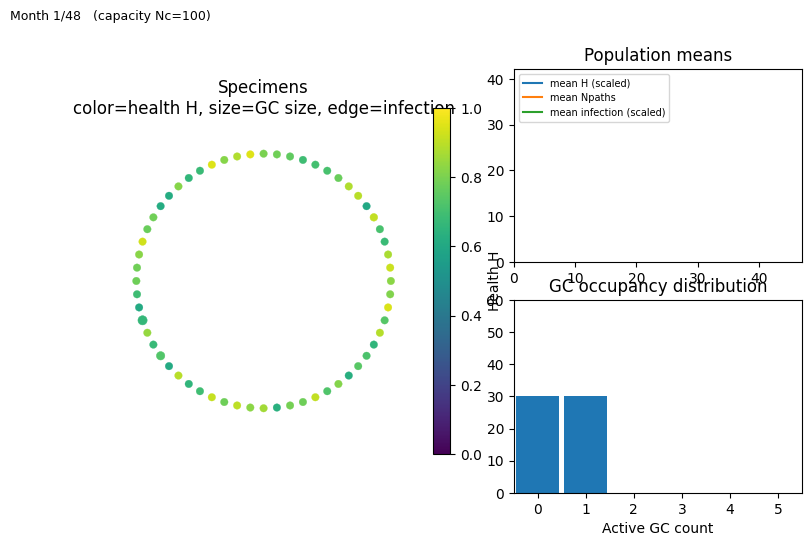

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

# Load NPZ
D = np.load("gc_governance_run.npz", allow_pickle=True)

snap_H = D["snap_H"]                  # (T, agents)
snap_gc = D["snap_gc_size"]
snap_occ = D["snap_gc_occ"]
snap_N = D["snap_Npaths"]
snap_inf = D["snap_inf_burden"]

mean_H = D["mean_H"]
mean_N = D["mean_Npaths"]
mean_inf = D["mean_inf"]

T = int(D["T"])
n_agents = int(D["n_agents"])
Nc = float(D["Nc"])

# Layout
fig = plt.figure(figsize=(9, 5.5))
gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1.0], height_ratios=[1, 1])

ax_sc = fig.add_subplot(gs[:, 0])
ax_ts = fig.add_subplot(gs[0, 1])
ax_hist = fig.add_subplot(gs[1, 1])

# Arrange specimens on a circle
theta = np.linspace(0, 2*np.pi, n_agents, endpoint=False)
xy = np.c_[np.cos(theta), np.sin(theta)]

# Scatter: color=health, size=GC size, edge=infection
sc = ax_sc.scatter(
    xy[:, 0], xy[:, 1],
    s=50,
    c=snap_H[0],
    cmap="viridis",
    vmin=0, vmax=1
)

ax_sc.set_title("Specimens\ncolor=health H, size=GC size, edge=infection")
ax_sc.set_xlim(-1.25, 1.25)
ax_sc.set_ylim(-1.25, 1.25)
ax_sc.set_aspect("equal")
ax_sc.axis("off")

fig.colorbar(sc, ax=ax_sc, fraction=0.05, pad=0.03, label="Health H")

# Time series (scaled to one axis)
H_scale = mean_N.max()
I_scale = mean_N.max() / 6.0

lineH, = ax_ts.plot([], [], label="mean H (scaled)")
lineN, = ax_ts.plot([], [], label="mean Npaths")
lineI, = ax_ts.plot([], [], label="mean infection (scaled)")

ax_ts.set_xlim(0, T-1)
ax_ts.set_ylim(0, mean_N.max()*1.1)
ax_ts.set_title("Population means")
ax_ts.legend(fontsize=7, loc="upper left")

# Histogram of GC occupancy
occ_bins = np.arange(-0.5, snap_occ.max()+1.5, 1.0)
bars = ax_hist.bar(
    occ_bins[:-1] + 0.5,
    np.zeros(len(occ_bins)-1),
    width=0.9
)

ax_hist.set_xlim(occ_bins[0], occ_bins[-1])
ax_hist.set_ylim(0, n_agents)
ax_hist.set_title("GC occupancy distribution")
ax_hist.set_xlabel("Active GC count")

time_text = fig.text(0.02, 0.97, "", fontsize=9)

def update(k):
    Hk = snap_H[k]
    gk = snap_gc[k]
    ik = snap_inf[k]
    ok = snap_occ[k]

    sc.set_array(Hk)
    sc.set_sizes(30 + 180*gk)
    sc.set_linewidths(0.2 + 0.9*(ik/6.0))

    x = np.arange(k+1)
    lineH.set_data(x, mean_H[:k+1]*H_scale)
    lineN.set_data(x, mean_N[:k+1])
    lineI.set_data(x, mean_inf[:k+1]*I_scale)

    counts, _ = np.histogram(ok, bins=occ_bins)
    for b, c in zip(bars, counts):
        b.set_height(c)

    time_text.set_text(f"Month {k+1}/{T}   (capacity Nc={Nc:.0f})")
    return sc, lineH, lineN, lineI, *bars

anim = FuncAnimation(fig, update, frames=T, interval=90, blit=False)

out_mp4 = "gc_governance_movie.mp4"
anim.save(out_mp4, writer=FFMpegWriter(fps=12))

print("Saved movie:", out_mp4)
Video(out_mp4, embed=True)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Saved NPZ: gc_governance_run.npz
Saved movie: gc_governance_movie.mp4


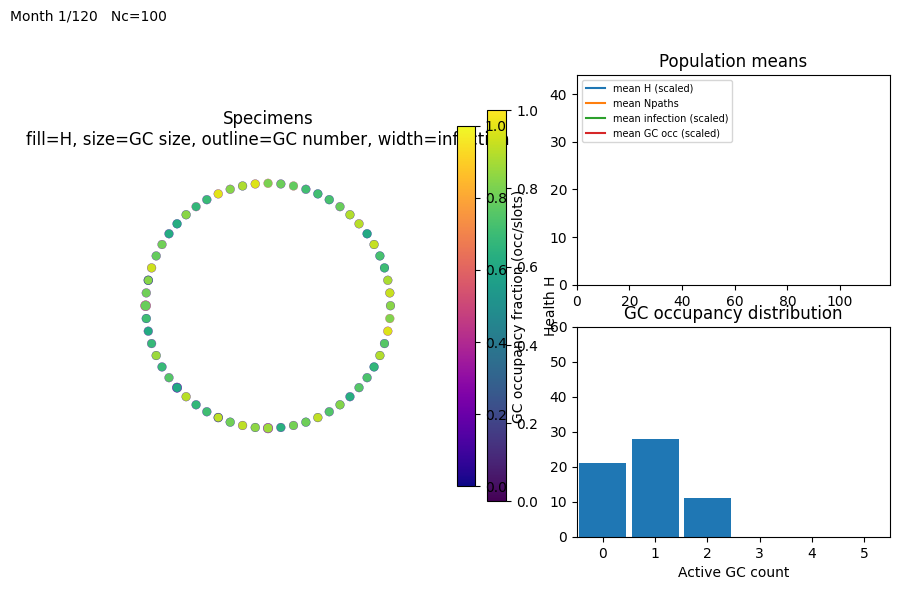

In [ ]:
# If you're in Colab, ensure ffmpeg exists for MP4 writing
!apt-get -qq update
!apt-get -qq install -y ffmpeg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import cm, colors
from IPython.display import Video

# -----------------------------
# Parameters
# -----------------------------
rng = np.random.default_rng(7)

T = 120
n_agents = 60

base_infection_rate = 0.12
season_amp = 0.07

Nc = 100.0
m_base = 0.35

# GC lifecycle parameters (tune gently)
base_life = 10.0        # months
seed_base = 0.05
seed_gain = 0.22

# -----------------------------
# State variables (per specimen)
# -----------------------------
age = np.zeros(n_agents)
sag = np.zeros(n_agents)
H = rng.uniform(0.6, 0.95, n_agents)
immune_skill = rng.uniform(0.4, 0.8, n_agents)

inf_burden = np.zeros(n_agents)
Npaths = rng.uniform(20, 60, n_agents)

# -----------------------------
# Finite follicles (slots) and transient GC occupancy
# -----------------------------
gc_slots = rng.integers(4, 13, n_agents)   # follicles per "compartment" (coarse-grained)
max_slots = int(gc_slots.max())

gc_slot_on = np.zeros((n_agents, max_slots), dtype=bool)
gc_slot_age = np.zeros((n_agents, max_slots), dtype=float)

# initial occupancy: 0..2 GCs
initial_occ = rng.integers(0, 3, n_agents)
for i in range(n_agents):
    if initial_occ[i] > 0:
        idx = np.arange(max_slots)
        idx = idx[idx < gc_slots[i]]
        if idx.size > 0:
            chosen = rng.choice(idx, size=min(initial_occ[i], idx.size), replace=False)
            gc_slot_on[i, chosen] = True
            gc_slot_age[i, chosen] = rng.uniform(0, 6, size=chosen.size)

gc_drive = np.zeros(n_agents)
gc_occ = gc_slot_on.sum(axis=1)
gc_size = np.zeros(n_agents)

# -----------------------------
# Storage (NPZ + movie)
# -----------------------------
snap_H = []
snap_gc_size = []
snap_gc_occ = []
snap_gc_slots = []
snap_Npaths = []
snap_inf = []
snap_sag = []

mean_H = []
mean_N = []
mean_inf = []
mean_occ = []
mean_gcsize = []

def seasonality(t):
    return season_amp * (1 + np.sin(2*np.pi*(t % 12)/12.0 - np.pi/2))

def step(t):
    global age, sag, H, immune_skill, inf_burden, Npaths
    global gc_drive, gc_slot_on, gc_slot_age, gc_occ, gc_size

    # Ageing + sag
    age[:] = age + 1.0
    sag[:] = np.clip(sag + 0.0012 + 0.002*(1 - H) + rng.normal(0, 0.001, n_agents), 0, 1)

    # Infection draw
    lam = base_infection_rate + seasonality(t)
    susceptibility = np.clip(0.6*sag + 0.4*(1 - immune_skill) + 0.2*(1 - H), 0, 1)
    p_inf = np.clip(lam * (0.5 + susceptibility), 0, 0.9)
    new_inf = rng.random(n_agents) < p_inf
    inf_burden[:] = np.clip(inf_burden*0.85 + new_inf.astype(float), 0, 6)

    # Antigenic drive (memory)
    gc_drive[:] = np.clip(gc_drive*0.90 + new_inf.astype(float)*(0.7 + 0.3*immune_skill), 0, 10)

    # Seed new GCs into free follicles (slots)
    free_slots = gc_slots - gc_slot_on.sum(axis=1)
    seed_prob = np.clip(seed_base + seed_gain*(gc_drive/10.0) - 0.12*sag, 0, 0.7)
    seed = (rng.random(n_agents) < seed_prob) & (free_slots > 0)

    for i in np.where(seed)[0]:
        free = np.where(~gc_slot_on[i])[0]
        free = free[free < gc_slots[i]]
        if free.size > 0:
            j = rng.choice(free)
            gc_slot_on[i, j] = True
            gc_slot_age[i, j] = 0.0

    # Age all active GCs
    gc_slot_age[gc_slot_on] += 1.0

    # GC death hazard increases with age-out, low drive, and sag
    life = np.clip(base_life*(1 - 0.6*sag), 3.0, 14.0)
    for i in range(n_agents):
        on = np.where(gc_slot_on[i])[0]
        if on.size == 0:
            continue
        hazard = (
            0.02
            + 0.10*(gc_slot_age[i, on] > life[i])
            + 0.12*(gc_drive[i] < 0.5)
            + 0.05*sag[i]
        )
        hazard = np.clip(hazard, 0, 0.7)
        die = rng.random(on.size) < hazard
        if die.any():
            dying = on[die]
            gc_slot_on[i, dying] = False
            gc_slot_age[i, dying] = 0.0

    # Derived GC number + size/activity (0..1)
    gc_occ[:] = gc_slot_on.sum(axis=1)
    slot_activity = np.clip((gc_drive/5.0) * (1 - 0.7*sag) * (0.6 + 0.4*H), 0, 1)
    gc_size[:] = np.clip((gc_occ / np.maximum(gc_slots, 1)) * slot_activity, 0, 1)

    # Migration / conquest mixing
    m_eff = np.clip(m_base + 0.5*sag + 0.25*(inf_burden/6.0), 0, 1)
    mix_inflation = 1.0 + 2.5*m_eff

    # Effective dimensionality proxy
    Npaths[:] = np.clip(Npaths + 8.0*gc_size*mix_inflation - 3.0*(gc_size < 0.2), 5, 800)

    # Governance overload -> health and skill
    overload = np.clip((Npaths - Nc) / Nc, 0, 5)
    dH = -0.02*overload - 0.01*(inf_burden/6.0) + 0.004*(inf_burden < 1.0) - 0.005*sag
    H[:] = np.clip(H + dH + rng.normal(0, 0.0025, n_agents), 0.05, 0.99)

    immune_skill[:] = np.clip(
        immune_skill + 0.001*(inf_burden < 1.0) - 0.003*overload + rng.normal(0, 0.001, n_agents),
        0.05, 0.98
    )

# -----------------------------
# Run + snapshot
# -----------------------------
for t in range(T):
    step(t)

    snap_H.append(H.copy())
    snap_gc_size.append(gc_size.copy())
    snap_gc_occ.append(gc_occ.copy())
    snap_gc_slots.append(gc_slots.copy())
    snap_Npaths.append(Npaths.copy())
    snap_inf.append(inf_burden.copy())
    snap_sag.append(sag.copy())

    mean_H.append(H.mean())
    mean_N.append(Npaths.mean())
    mean_inf.append(inf_burden.mean())
    mean_occ.append(gc_occ.mean())
    mean_gcsize.append(gc_size.mean())

snap_H = np.array(snap_H)
snap_gc_size = np.array(snap_gc_size)
snap_gc_occ = np.array(snap_gc_occ)
snap_gc_slots = np.array(snap_gc_slots)
snap_Npaths = np.array(snap_Npaths)
snap_inf = np.array(snap_inf)
snap_sag = np.array(snap_sag)

mean_H = np.array(mean_H)
mean_N = np.array(mean_N)
mean_inf = np.array(mean_inf)
mean_occ = np.array(mean_occ)
mean_gcsize = np.array(mean_gcsize)

# Save NPZ
np.savez(
    "gc_governance_run.npz",
    T=T, n_agents=n_agents,
    Nc=Nc, m_base=m_base,
    base_infection_rate=base_infection_rate,
    season_amp=season_amp,
    base_life=base_life,
    seed_base=seed_base,
    seed_gain=seed_gain,
    gc_slots=gc_slots,
    mean_H=mean_H,
    mean_Npaths=mean_N,
    mean_inf=mean_inf,
    mean_gc_occ=mean_occ,
    mean_gc_size=mean_gcsize,
    snap_H=snap_H,
    snap_gc_size=snap_gc_size,
    snap_gc_occ=snap_gc_occ,
    snap_gc_slots=snap_gc_slots,
    snap_Npaths=snap_Npaths,
    snap_inf_burden=snap_inf,
    snap_sag=snap_sag,
)
print("Saved NPZ: gc_governance_run.npz")

# -----------------------------
# Movie (shows both GC number + GC size)
# -----------------------------
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1.25, 1.0], height_ratios=[1, 1])

ax_sc = fig.add_subplot(gs[:, 0])
ax_ts = fig.add_subplot(gs[0, 1])
ax_hist = fig.add_subplot(gs[1, 1])

theta = np.linspace(0, 2*np.pi, n_agents, endpoint=False)
xy = np.c_[np.cos(theta), np.sin(theta)]

# Fill color: H
sc = ax_sc.scatter(
    xy[:, 0], xy[:, 1],
    s=40 + 200*snap_gc_size[0],        # dot size: GC size/activity
    c=snap_H[0],
    cmap="viridis",
    vmin=0, vmax=1
)

ax_sc.set_title("Specimens\nfill=H, size=GC size, outline=GC number, width=infection")
ax_sc.set_xlim(-1.25, 1.25)
ax_sc.set_ylim(-1.25, 1.25)
ax_sc.set_aspect("equal")
ax_sc.axis("off")
fig.colorbar(sc, ax=ax_sc, fraction=0.05, pad=0.03, label="Health H")

# Outline color encodes occupancy fraction (gc_occ / gc_slots)
occ_norm = colors.Normalize(vmin=0, vmax=1)
occ_cmap = cm.plasma

def outline_colors(k):
    frac = snap_gc_occ[k] / np.maximum(snap_gc_slots[k], 1)
    return occ_cmap(occ_norm(frac))

sc.set_edgecolors(outline_colors(0))
sc.set_linewidths(0.2 + 0.9*(snap_inf[0]/6.0))   # thickness: infection burden

# Time series (scaled to one axis)
H_scale = mean_N.max()
I_scale = mean_N.max()/6.0

lineH, = ax_ts.plot([], [], label="mean H (scaled)")
lineN, = ax_ts.plot([], [], label="mean Npaths")
lineI, = ax_ts.plot([], [], label="mean infection (scaled)")
lineOcc, = ax_ts.plot([], [], label="mean GC occ (scaled)")

ax_ts.set_xlim(0, T-1)
ax_ts.set_ylim(0, mean_N.max()*1.15)
ax_ts.set_title("Population means")
ax_ts.legend(fontsize=7, loc="upper left")

Occ_scale = mean_N.max() / max(1.0, mean_occ.max())

# Histogram: GC occupancy counts
occ_bins = np.arange(-0.5, snap_gc_occ.max()+1.5, 1.0)
bars = ax_hist.bar(occ_bins[:-1] + 0.5, np.zeros(len(occ_bins)-1), width=0.9)
ax_hist.set_xlim(occ_bins[0], occ_bins[-1])
ax_hist.set_ylim(0, n_agents)
ax_hist.set_title("GC occupancy distribution")
ax_hist.set_xlabel("Active GC count")

time_text = fig.text(0.02, 0.97, "", fontsize=10)

# Add a small legend for outline color
sm = cm.ScalarMappable(norm=occ_norm, cmap=occ_cmap)
sm.set_array([])
cbar2 = fig.colorbar(sm, ax=ax_sc, fraction=0.05, pad=0.10)
cbar2.set_label("GC occupancy fraction (occ/slots)")

def update(k):
    sc.set_array(snap_H[k])
    sc.set_sizes(40 + 200*snap_gc_size[k])
    sc.set_edgecolors(outline_colors(k))
    sc.set_linewidths(0.2 + 0.9*(snap_inf[k]/6.0))

    x = np.arange(k+1)
    lineH.set_data(x, mean_H[:k+1]*H_scale)
    lineN.set_data(x, mean_N[:k+1])
    lineI.set_data(x, mean_inf[:k+1]*I_scale)
    lineOcc.set_data(x, mean_occ[:k+1]*Occ_scale)

    counts, _ = np.histogram(snap_gc_occ[k], bins=occ_bins)
    for b, c in zip(bars, counts):
        b.set_height(c)

    time_text.set_text(f"Month {k+1}/{T}   Nc={Nc:.0f}")
    return sc, lineH, lineN, lineI, lineOcc, *bars

anim = FuncAnimation(fig, update, frames=T, interval=90, blit=False)

out_mp4 = "gc_governance_movie.mp4"
anim.save(out_mp4, writer=FFMpegWriter(fps=12))
print("Saved movie:", out_mp4)

Video(out_mp4, embed=True)

In [ ]:
import numpy as np

# -----------------------------
# GC-FIRST SIMULATION: FOLLICLES AS THE MODEL
# One follicle hosts 0/1 GC at a time.
# -----------------------------

rng = np.random.default_rng(7)

# Time axis
T = 1200               # steps (e.g. months)
n_fol = 120             # follicles (a lymphoid region / node-scale abstraction)

# "Ageing / architecture" (sag) — GC support degradation over time
sag = 0.0               # 0..1, increases slowly

# Infection/antigen schedule (shared)
base_challenge = 0.06   # per step probability of challenge pulse
season_amp = 0.04       # optional seasonality

def seasonality(t):
    return season_amp * (1 + np.sin(2*np.pi*(t % 12)/12.0 - np.pi/2))

# Migration coupling between follicles (GC-derived reseeding)
migrate_rate = 0.06     # probability per step that each active GC emits a "migrant seed" event

# GC lifecycle parameters (biologically interpretable knobs)
gc_seed_base = 0.02     # baseline probability a follicle seeds a GC on antigen
gc_seed_gain = 0.25     # how strongly antigen drive increases seeding probability
gc_growth_gain = 0.18   # how strongly antigen + Tfh grow the GC
gc_decay_base = 0.08    # natural contraction rate per step
gc_max_life = 18        # max GC lifetime (steps) before resolution pressure increases

# Tfh support proxy (declines with sag; per follicle stochasticity)
# Represents the ability to sustain DZ/LZ cycling / selection architecture.
t_help = rng.uniform(0.7, 1.0, n_fol)

# Follicle state variables
gc_on = np.zeros(n_fol, dtype=bool)            # GC present?
gc_age = np.zeros(n_fol, dtype=float)          # time since initiation
gc_size = np.zeros(n_fol, dtype=float)         # 0..1 activity/size proxy
gc_quality = np.zeros(n_fol, dtype=float)      # 0..1 "selection coherence / quality" proxy
antigen_drive = np.zeros(n_fol, dtype=float)   # 0..1 local antigenic drive memory

# A simple “clone-sharing” proxy: tracks whether a follicle’s GC was reseeded by a migrant recently
recent_migrant = np.zeros(n_fol, dtype=float)  # decays over time

# Outputs
mean_gc_count = np.zeros(T)
mean_gc_size = np.zeros(T)
mean_gc_quality = np.zeros(T)
mean_antigen = np.zeros(T)
mean_migrant = np.zeros(T)

# -----------------------------
# Main loop
# -----------------------------
for t in range(T):

    # Ageing / sag increases gradually; worsens GC support
    sag = np.clip(sag + 0.0015 + rng.normal(0, 0.0003), 0, 1)

    # Global antigenic challenge pulse (shared ecology)
    lam = base_challenge + seasonality(t)
    challenge = rng.random() < np.clip(lam, 0, 0.5)

    # Local antigen drive: rises with challenge, decays otherwise
    antigen_drive = np.clip(antigen_drive*0.86 + (0.7 if challenge else 0.0), 0, 1)

    # Effective Tfh support declines with sag (architecture/coordination loss)
    # plus some slow drift noise
    t_help = np.clip(t_help + rng.normal(0, 0.002, n_fol) - 0.015*sag, 0.2, 1.0)

    # -------------------------
    # Migration/reseeding events (Kelsoe-style coupling between follicles)
    # Each active GC can emit a migrant that tries to seed another follicle.
    # -------------------------
    active_idx = np.where(gc_on)[0]
    n_emit = 0
    if active_idx.size > 0:
        # number of migrant emission attempts
        emit = rng.random(active_idx.size) < migrate_rate
        emitters = active_idx[emit]
        n_emit = emitters.size

        for src in emitters:
            # choose a target follicle different from src
            tgt = int(rng.integers(0, n_fol-1))
            if tgt >= src:
                tgt += 1

            # migrant "reseeding" increases antigen_drive slightly and flags recent migrant coupling
            antigen_drive[tgt] = np.clip(antigen_drive[tgt] + 0.10, 0, 1)
            recent_migrant[tgt] = 1.0

            # If target has no GC, it may seed a GC even without global challenge
            if not gc_on[tgt]:
                # seeding probability depends on antigen drive + Tfh, penalised by sag
                p_seed = gc_seed_base + gc_seed_gain*antigen_drive[tgt]*t_help[tgt]*(1 - 0.7*sag)
                if rng.random() < np.clip(p_seed, 0, 0.6):
                    gc_on[tgt] = True
                    gc_age[tgt] = 0.0
                    gc_size[tgt] = 0.10
                    # migrant-reseeded GCs start with more interference risk: lower initial quality
                    gc_quality[tgt] = 0.45 + 0.20*t_help[tgt] - 0.20*recent_migrant[tgt]

    # migrant flag decays
    recent_migrant = np.clip(recent_migrant*0.85, 0, 1)

    # -------------------------
    # GC seeding in response to challenge (follicle-level)
    # -------------------------
    if challenge:
        # follicles without GC can initiate one with probability depending on antigen drive + Tfh, penalised by sag
        candidates = np.where(~gc_on)[0]
        if candidates.size > 0:
            p_seed = gc_seed_base + gc_seed_gain*antigen_drive[candidates]*t_help[candidates]*(1 - 0.7*sag)
            seed = rng.random(candidates.size) < np.clip(p_seed, 0, 0.7)
            seed_idx = candidates[seed]
            gc_on[seed_idx] = True
            gc_age[seed_idx] = 0.0
            gc_size[seed_idx] = 0.12
            # initial quality depends on Tfh support; sag penalises organisation
            gc_quality[seed_idx] = np.clip(0.55 + 0.35*t_help[seed_idx] - 0.25*sag, 0, 1)

    # -------------------------
    # GC growth / maintenance / resolution
    # -------------------------
    on = np.where(gc_on)[0]
    if on.size > 0:
        gc_age[on] += 1.0

        # growth term: antigen drive + Tfh support, penalised by sag
        growth = gc_growth_gain * antigen_drive[on] * t_help[on] * (1 - 0.6*sag)

        # decay: natural contraction + extra decay when old or when antigen drive is low
        age_pressure = (gc_age[on] > gc_max_life).astype(float)
        low_antigen = (antigen_drive[on] < 0.15).astype(float)
        decay = gc_decay_base * (1 + 1.2*age_pressure + 0.8*low_antigen + 0.6*sag)

        # update size
        gc_size[on] = np.clip(gc_size[on] + growth - decay, 0, 1)

        # quality improves with sustained Tfh help and moderate size, but is harmed by high migrant coupling and sag
        # (this is a proxy for coherent DZ/LZ cycling / selection fidelity)
        qual_gain = 0.03 * t_help[on] * (gc_size[on] > 0.2)
        qual_loss = 0.04 * sag + 0.05 * recent_migrant[on]
        gc_quality[on] = np.clip(gc_quality[on] + qual_gain - qual_loss, 0, 1)

        # resolution: GC turns off when it shrinks to near-zero or exceeds extreme age
        resolve = (gc_size[on] < 0.05) | (gc_age[on] > (gc_max_life + 12))
        res_idx = on[resolve]
        if res_idx.size > 0:
            gc_on[res_idx] = False
            gc_age[res_idx] = 0.0
            gc_size[res_idx] = 0.0
            gc_quality[res_idx] = 0.0

    # -------------------------
    # Record summary
    # -------------------------
    mean_gc_count[t] = gc_on.mean() * n_fol
    mean_gc_size[t] = gc_size[gc_on].mean() if gc_on.any() else 0.0
    mean_gc_quality[t] = gc_quality[gc_on].mean() if gc_on.any() else 0.0
    mean_antigen[t] = antigen_drive.mean()
    mean_migrant[t] = recent_migrant.mean()

# -----------------------------
# Save NPZ
# -----------------------------
np.savez(
    "gc_follicle_first_run.npz",
    T=T,
    n_fol=n_fol,
    base_challenge=base_challenge,
    season_amp=season_amp,
    migrate_rate=migrate_rate,
    gc_seed_base=gc_seed_base,
    gc_seed_gain=gc_seed_gain,
    gc_growth_gain=gc_growth_gain,
    gc_decay_base=gc_decay_base,
    gc_max_life=gc_max_life,

    mean_gc_count=mean_gc_count,
    mean_gc_size=mean_gc_size,
    mean_gc_quality=mean_gc_quality,
    mean_antigen=mean_antigen,
    mean_migrant=mean_migrant,

    # final states (for inspection)
    sag=sag,
    t_help=t_help,
    gc_on=gc_on,
    gc_age=gc_age,
    gc_size=gc_size,
    gc_quality=gc_quality,
    antigen_drive=antigen_drive,
    recent_migrant=recent_migrant,
)

print("Saved: gc_follicle_first_run.npz")
print("Final: sag=", float(sag), " active GCs=", int(gc_on.sum()))
print("Final mean GC size (active only)=", float(gc_size[gc_on].mean()) if gc_on.any() else 0.0)
print("Final mean GC quality (active only)=", float(gc_quality[gc_on].mean()) if gc_on.any() else 0.0)
print("Final mean migrant coupling=", float(recent_migrant.mean()))

Saved: gc_follicle_first_run.npz
Final: sag= 1.0  active GCs= 0
Final mean GC size (active only)= 0.0
Final mean GC quality (active only)= 0.0
Final mean migrant coupling= 3.2348324519394874e-72


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Saved movie: gc_follicle_first_movie.mp4


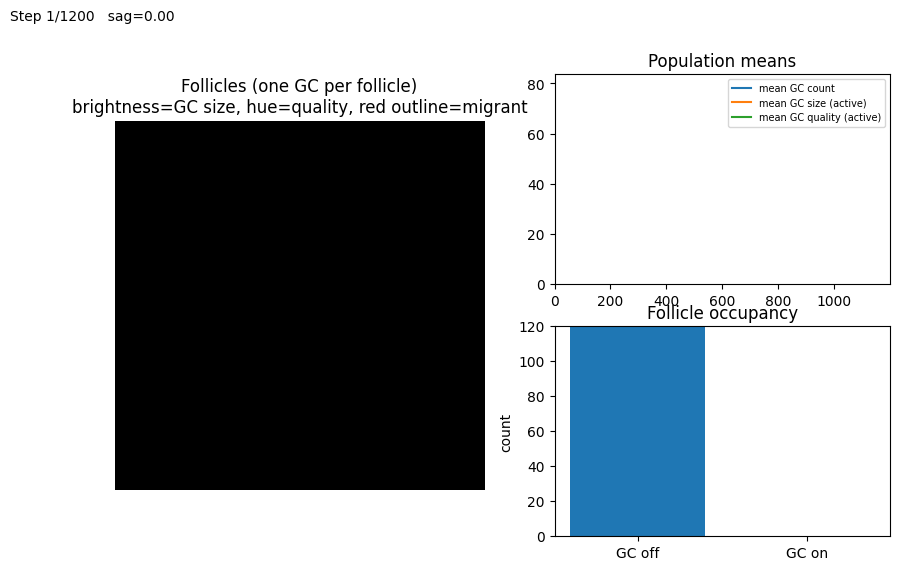

In [ ]:
# If you're in Colab, ensure ffmpeg exists for MP4 writing
!apt-get -qq update
!apt-get -qq install -y ffmpeg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import colors
from IPython.display import Video

# -----------------------------
# Load NPZ
# -----------------------------
D = np.load("gc_follicle_first_run.npz", allow_pickle=True)

T = int(D["T"])
n_fol = int(D["n_fol"])

# These are means (time series)
mean_gc_count = D["mean_gc_count"]
mean_gc_size = D["mean_gc_size"]
mean_gc_quality = D["mean_gc_quality"]
mean_antigen = D["mean_antigen"]
mean_migrant = D["mean_migrant"]

# Final states are saved, but for a movie we need per-time snapshots.
# So: if you want a true movie over time, the sim should also save time-resolved arrays.
# Here we regenerate an illustrative movie using a lightweight replay by re-running the sim
# with the same RNG seed and parameters stored in the NPZ.

# -----------------------------
# Replay the sim to get per-time snapshots (faithful to the saved parameters)
# -----------------------------
rng = np.random.default_rng(7)

base_challenge = float(D["base_challenge"])
season_amp = float(D["season_amp"])
migrate_rate = float(D["migrate_rate"])
gc_seed_base = float(D["gc_seed_base"])
gc_seed_gain = float(D["gc_seed_gain"])
gc_growth_gain = float(D["gc_growth_gain"])
gc_decay_base = float(D["gc_decay_base"])
gc_max_life = int(D["gc_max_life"])

sag = 0.0
t_help = rng.uniform(0.7, 1.0, n_fol)

gc_on = np.zeros(n_fol, dtype=bool)
gc_age = np.zeros(n_fol, dtype=float)
gc_size = np.zeros(n_fol, dtype=float)
gc_quality = np.zeros(n_fol, dtype=float)
antigen_drive = np.zeros(n_fol, dtype=float)
recent_migrant = np.zeros(n_fol, dtype=float)

def seasonality(t):
    return season_amp * (1 + np.sin(2*np.pi*(t % 12)/12.0 - np.pi/2))

# snapshots
snap_on = np.zeros((T, n_fol), dtype=np.uint8)
snap_size = np.zeros((T, n_fol), dtype=np.float32)
snap_qual = np.zeros((T, n_fol), dtype=np.float32)
snap_mig = np.zeros((T, n_fol), dtype=np.float32)

for t in range(T):
    sag = np.clip(sag + 0.0015 + rng.normal(0, 0.0003), 0, 1)

    lam = base_challenge + seasonality(t)
    challenge = rng.random() < np.clip(lam, 0, 0.5)

    antigen_drive = np.clip(antigen_drive*0.86 + (0.7 if challenge else 0.0), 0, 1)

    t_help = np.clip(t_help + rng.normal(0, 0.002, n_fol) - 0.015*sag, 0.2, 1.0)

    # migration reseeding from active GCs
    active_idx = np.where(gc_on)[0]
    if active_idx.size > 0:
        emit = rng.random(active_idx.size) < migrate_rate
        emitters = active_idx[emit]
        for src in emitters:
            tgt = int(rng.integers(0, n_fol-1))
            if tgt >= src:
                tgt += 1
            antigen_drive[tgt] = np.clip(antigen_drive[tgt] + 0.10, 0, 1)
            recent_migrant[tgt] = 1.0
            if not gc_on[tgt]:
                p_seed = gc_seed_base + gc_seed_gain*antigen_drive[tgt]*t_help[tgt]*(1 - 0.7*sag)
                if rng.random() < np.clip(p_seed, 0, 0.6):
                    gc_on[tgt] = True
                    gc_age[tgt] = 0.0
                    gc_size[tgt] = 0.10
                    gc_quality[tgt] = np.clip(0.45 + 0.20*t_help[tgt] - 0.20*recent_migrant[tgt], 0, 1)

    recent_migrant = np.clip(recent_migrant*0.85, 0, 1)

    # seeding on global challenge
    if challenge:
        candidates = np.where(~gc_on)[0]
        if candidates.size > 0:
            p_seed = gc_seed_base + gc_seed_gain*antigen_drive[candidates]*t_help[candidates]*(1 - 0.7*sag)
            seed = rng.random(candidates.size) < np.clip(p_seed, 0, 0.7)
            seed_idx = candidates[seed]
            gc_on[seed_idx] = True
            gc_age[seed_idx] = 0.0
            gc_size[seed_idx] = 0.12
            gc_quality[seed_idx] = np.clip(0.55 + 0.35*t_help[seed_idx] - 0.25*sag, 0, 1)

    # growth/decay/quality/resolution
    on = np.where(gc_on)[0]
    if on.size > 0:
        gc_age[on] += 1.0

        growth = gc_growth_gain * antigen_drive[on] * t_help[on] * (1 - 0.6*sag)
        age_pressure = (gc_age[on] > gc_max_life).astype(float)
        low_antigen = (antigen_drive[on] < 0.15).astype(float)
        decay = gc_decay_base * (1 + 1.2*age_pressure + 0.8*low_antigen + 0.6*sag)

        gc_size[on] = np.clip(gc_size[on] + growth - decay, 0, 1)

        qual_gain = 0.03 * t_help[on] * (gc_size[on] > 0.2)
        qual_loss = 0.04 * sag + 0.05 * recent_migrant[on]
        gc_quality[on] = np.clip(gc_quality[on] + qual_gain - qual_loss, 0, 1)

        resolve = (gc_size[on] < 0.05) | (gc_age[on] > (gc_max_life + 12))
        res_idx = on[resolve]
        if res_idx.size > 0:
            gc_on[res_idx] = False
            gc_age[res_idx] = 0.0
            gc_size[res_idx] = 0.0
            gc_quality[res_idx] = 0.0

    # store
    snap_on[t] = gc_on.astype(np.uint8)
    snap_size[t] = gc_size
    snap_qual[t] = gc_quality
    snap_mig[t] = recent_migrant


# -----------------------------
# Map follicles to a grid for display
# -----------------------------
side = int(np.ceil(np.sqrt(n_fol)))
pad = side*side - n_fol

def to_grid(v, fill=0.0):
    if v.ndim == 1:
        vv = np.concatenate([v, np.full(pad, fill, dtype=v.dtype)])
        return vv.reshape(side, side)
    raise ValueError("Expected 1D vector")

# Composite image: hue=quality, value=size, mask=no-GC
cmap = plt.get_cmap("viridis")
norm01 = colors.Normalize(0, 1)

# -----------------------------
# Build animation
# -----------------------------
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1.1, 1.0], height_ratios=[1, 1])

ax_img = fig.add_subplot(gs[:, 0])
ax_ts = fig.add_subplot(gs[0, 1])
ax_bar = fig.add_subplot(gs[1, 1])

ax_img.set_title("Follicles (one GC per follicle)\nbrightness=GC size, hue=quality, red outline=migrant")
ax_img.axis("off")

# initial frame image
size0 = to_grid(snap_size[0])
qual0 = to_grid(snap_qual[0])
on0 = to_grid(snap_on[0])

rgb0 = cmap(norm01(qual0))[..., :3] * size0[..., None]
rgb0[on0 < 0.5] = 0.0  # no GC -> black
im = ax_img.imshow(rgb0, interpolation="nearest")

# migrant overlay as red border mask
mig0 = to_grid(snap_mig[0])
mig_mask = (mig0 > 0.6).astype(float)
mig_im = ax_img.imshow(
    np.dstack([mig_mask, np.zeros_like(mig_mask), np.zeros_like(mig_mask), 0.35*mig_mask]),
    interpolation="nearest"
)

# time series (means)
line_count, = ax_ts.plot([], [], label="mean GC count")
line_size, = ax_ts.plot([], [], label="mean GC size (active)")
line_qual, = ax_ts.plot([], [], label="mean GC quality (active)")
ax_ts.set_xlim(0, T-1)
ax_ts.set_ylim(0, max(mean_gc_count.max(), 1.0)*1.1)
ax_ts.set_title("Population means")
ax_ts.legend(fontsize=7, loc="upper right")

# occupancy bar: how many follicles have GC this frame
bars = ax_bar.bar(["GC off", "GC on"], [n_fol - snap_on[0].sum(), snap_on[0].sum()])
ax_bar.set_ylim(0, n_fol)
ax_bar.set_title("Follicle occupancy")
ax_bar.set_ylabel("count")

time_text = fig.text(0.02, 0.97, "", fontsize=10)

def update(k):
    size = to_grid(snap_size[k])
    qual = to_grid(snap_qual[k])
    on = to_grid(snap_on[k])

    rgb = cmap(norm01(qual))[..., :3] * size[..., None]
    rgb[on < 0.5] = 0.0
    im.set_data(rgb)

    mig = to_grid(snap_mig[k])
    m = (mig > 0.6).astype(float)
    mig_im.set_data(np.dstack([m, np.zeros_like(m), np.zeros_like(m), 0.35*m]))

    x = np.arange(k+1)
    line_count.set_data(x, mean_gc_count[:k+1])
    line_size.set_data(x, mean_gc_size[:k+1] * mean_gc_count.max())
    line_qual.set_data(x, mean_gc_quality[:k+1] * mean_gc_count.max())

    on_count = int(snap_on[k].sum())
    bars[0].set_height(n_fol - on_count)
    bars[1].set_height(on_count)

    time_text.set_text(f"Step {k+1}/{T}   sag={float(np.clip(0.0015*k,0,1)):.2f}")
    return im, mig_im, line_count, line_size, line_qual, *bars

anim = FuncAnimation(fig, update, frames=T, interval=90, blit=False)

out_mp4 = "gc_follicle_first_movie.mp4"
anim.save(out_mp4, writer=FFMpegWriter(fps=12))
print("Saved movie:", out_mp4)

Video(out_mp4, embed=True)